
Evaluating checkpoints/checkpoint_d500_B500_R111_20241118_163035_step_499.pt

Evaluating risk curve for d=500, label_flip_p=0.0
Position 10: accuracy = 1.000
Position 20: accuracy = 1.000
Position 30: accuracy = 1.000
Position 40: accuracy = 1.000
Position 50: accuracy = 1.000
Position 60: accuracy = 1.000

Evaluating risk curve for d=500, label_flip_p=0.35
Position 10: accuracy = 0.998
Position 20: accuracy = 0.964
Position 30: accuracy = 0.908
Position 40: accuracy = 0.850
Position 50: accuracy = 0.806
Position 60: accuracy = 0.770


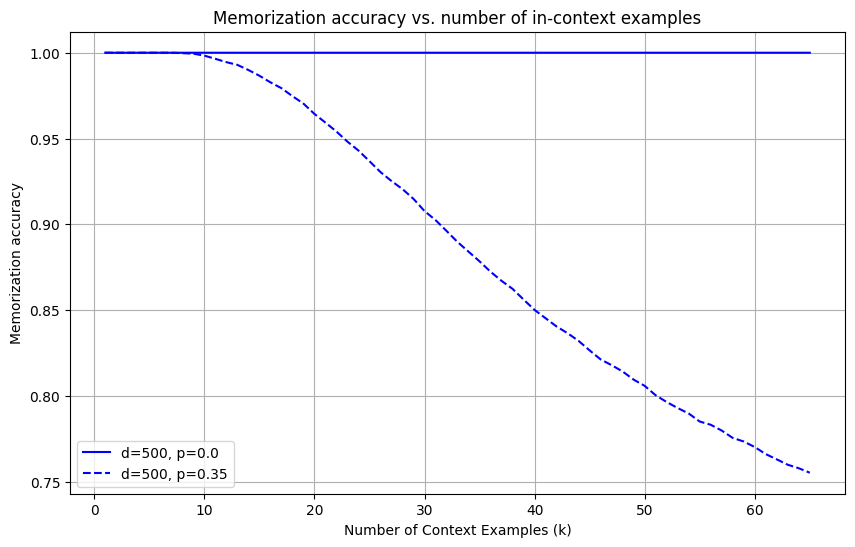

In [3]:
from classification_icl import ExperimentConfig, LinearTransformer, GaussianMixtureDataset
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from dataclasses import asdict
from typing import List, Dict, Any, Tuple

class CheckpointEvaluator:
    """Evaluator class for analyzing trained model checkpoints"""
    
    def __init__(self, checkpoint_dir: str):
        self.checkpoint_dir = Path(checkpoint_dir)
        
    def load_checkpoint(self, checkpoint_path: str) -> Tuple[LinearTransformer, ExperimentConfig]:
        """Load model and config from checkpoint"""
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        config = ExperimentConfig(**asdict(checkpoint['config']))
        model = LinearTransformer(config.d)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        return model, config

    def evaluate_risk_curves(
        self,
        model: LinearTransformer,
        d: int,
        max_seq_length: int = 50,
        num_samples: int = 1000,
        label_flip_ps: List[float] = [0.0, 0.35],
        device: str = 'cpu'
    ) -> Dict[str, np.ndarray]:
        """
        Evaluate model's risk curve - accuracy vs number of context examples.
        Uses the model's compute_in_context_preds method for efficiency.
        
        Args:
            model: Trained LinearTransformer model
            d: Input dimension
            max_seq_length: Maximum sequence length to evaluate
            num_samples: Number of sequences to evaluate
            label_flip_ps: List of label flip probabilities to evaluate
            device: Device to run evaluation on
            
        Returns:
            Dictionary mapping label_flip_p to arrays of accuracies at each position
        """
        model = model.to(device)
        results = {}
        R = d ** 0.3
        
        for label_flip_p in label_flip_ps:
            print(f"\nEvaluating risk curve for d={d}, label_flip_p={label_flip_p}")
            
            # Create dataset with reasonable size N
            dataset = GaussianMixtureDataset(
                d=d,
                N=max_seq_length,
                B=num_samples,
                R=R,  # Using R=1.0 like in test
                is_validation=True,
                label_flip_p=label_flip_p
            )
            
            # Get all data at once
            context_x, context_y, _, _ = [t.to(device) for t in dataset[0]]
            
            # Storage for accuracies at each position
            position_accuracies = np.zeros(max_seq_length-1)
            
            with torch.no_grad():
                for k in range(1, max_seq_length):
                    curr_context_x = context_x[:, :k]
                    curr_context_y = context_y[:, :k]
                    
                    preds = model.compute_in_context_preds(curr_context_x, curr_context_y)
                    accuracy = (preds == curr_context_y).float().mean().item()
                    position_accuracies[k-1] = accuracy
                    
                    if k % 10 == 0:
                        print(f"Position {k}: accuracy = {accuracy:.3f}")
            
            results[label_flip_p] = position_accuracies
            
        return results


    def plot_risk_curves(self, results_by_d: Dict[int, Dict[float, np.ndarray]], save_path: str = None):
        """
        Plot risk curves for different dimensions and label flip probabilities.
        
        Args:
            results_by_d: Dictionary mapping dimension d to results from evaluate_risk_curves
            save_path: Optional path to save the plot
        """
        plt.figure(figsize=(10, 6))
        colors = ['blue', 'red', 'green']
        styles = ['-', '--']
        
        for i, (d, results) in enumerate(sorted(results_by_d.items())):
            for j, (label_flip_p, accuracies) in enumerate(results.items()):
                x = np.arange(1, len(accuracies) + 1)
                label = f'd={d}, p={label_flip_p}'
                plt.plot(x, accuracies, label=label, color=colors[i], linestyle=styles[j])
        
        plt.xlabel('Number of Context Examples (k)')
        plt.ylabel('Memorization accuracy')
        plt.title('Memorization accuracy vs. number of in-context examples')
        #plt.ylabel('Accuracy on (k+1)th Example')
        #plt.title('Risk Curves for Different Dimensions and Label Noise')
        plt.legend()
        plt.grid(True)
        
        if save_path:
            plt.savefig(save_path)
            print(f"Plot saved to {save_path}")
        else:
            plt.show()
            
    def evaluate_checkpoint(self, checkpoint_file: str) -> Dict[int, Dict[float, np.ndarray]]:
        """
        Evaluate a single checkpoint and return risk curves.
        
        Args:
            checkpoint_file: Path to checkpoint file
            
        Returns:
            Results dictionary for plotting risk curves
        """
        print(f"\nEvaluating {checkpoint_file}")
        model, config = self.load_checkpoint(checkpoint_file)
        results = self.evaluate_risk_curves(
            model=model,
            d=config.d,
            max_seq_length=3*int(config.d**0.5),
            num_samples=1000,
            label_flip_ps=[0.0, 0.35],
            device='cuda' if torch.cuda.is_available() else 'cpu'
        )
        return {config.d: results}

# Example usage:
def main():
    evaluator = CheckpointEvaluator('checkpoints/')
    
    # Collect results for all dimensions
    all_results = {}
    # dimensions = [50, 500, 2500]
    dimensions = [500]
    
    for d in dimensions:
        # checkpoint_file = f"checkpoints/checkpoint_d{d}_*.pt"  # Adjust pattern as needed
        matches = list(Path('checkpoints/').glob(f"checkpoint_d{d}*.pt"))
        if matches:
            results = evaluator.evaluate_checkpoint(str(matches[0]))
            all_results.update(results)
    
    # Plot combined results
    evaluator.plot_risk_curves(all_results, save_path=None)

if __name__ == "__main__":
    main()